In [81]:
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("max_colwidth", 100)

In [4]:
files_list = glob.glob("../results/*.json")
dfs = []
for f in files_list:
    embedding_retrieval_type = "_".join(f.split("_")[3:-1]) + "_pooling"
    df = pd.read_json(f)
    df["embedding_retrieval_type"] = embedding_retrieval_type
    dfs.append(df)

In [5]:
full_results = pd.concat(dfs)

In [302]:
full_results

,Dataset,Dataset Size,Model,Computation Time,embedding_retrieval_type,embedding_model,nr_topics,min_topic_size,npmi,diversity
0,trump,44252,BERTopic,33.397249,embedding_concat_last_four_layers_mean_pooling,all-MiniLM-L12-v2,10,15,0.049033,0.800000
1,trump,44252,BERTopic,34.737347,embedding_concat_last_four_layers_mean_pooling,all-MiniLM-L12-v2,20,15,0.051549,0.668421
2,trump,44252,BERTopic,33.979037,embedding_concat_last_four_layers_mean_pooling,all-MiniLM-L12-v2,30,15,0.032970,0.644828
3,trump,44252,BERTopic,33.890322,embedding_concat_last_four_layers_mean_pooling,all-MiniLM-L12-v2,40,15,-0.009907,0.661538
4,trump,44252,BERTopic,33.198666,embedding_concat_last_four_layers_mean_pooling,all-MiniLM-L12-v2,50,15,0.010276,0.675510
...,...,...,...,...,...,...,...,...,...,...
0,trump,44252,BERTopic,82.198612,embedding_layer_output_mean_pooling,all-MiniLM-L12-v2,10,15,-0.002062,0.866667
1,trump,44252,BERTopic,60.724529,embedding_layer_output_mean_pooling,all-MiniLM-L12-v2,20,15,-0.019422,0.810526
2,trump,44252,BERTopic,61.065391,embedding_layer_output_mean_pooling,all-MiniLM-L12-v2,30,15,-0.007334,0.813793
3,trump,44252,BERTopic,57.015851,embedding_layer_output_mean_pooling,all-MiniLM-L12-v2,40,15,-0.021815,0.828205


In [12]:
keys_to_extract = ["embedding_model", "nr_topics", "min_topic_size"]
for key in keys_to_extract:
    full_results[key] = full_results["Params"].apply(lambda x: x.get(key, None))
full_results.drop("Params", axis=1, inplace=True)

In [14]:
keys_to_extract = ["npmi", "diversity"]
for key in keys_to_extract:
    full_results[key] = full_results["Scores"].apply(lambda x: x.get(key, None))
full_results.drop("Scores", axis=1, inplace=True)

In [294]:
results_grouped = full_results.groupby(
    [full_results["embedding_retrieval_type"], full_results["nr_topics"]], as_index=False
)[["nr_topics", "npmi", "diversity", "Computation Time"]].mean()

In [295]:
def rename_embedding_type(name):
    # Split the name into parts
    parts = name.split("_")

    # Define the new names for each part
    new_name_parts = {
        "concat": "Concat",
        "sum": "Sum",
        "last": "Last",
        "second": "Second",
        "all": "All",
        "four": "Four",
        "layers": "Layers",
        "layer": "Layer",
        "output": "Output",
        "hidden": "Hidden",
    }

    # Determine the pooling type and place it in parentheses
    pooling = parts[-2].upper() if parts[-2] == "cls" else parts[-2].capitalize()
    pooling_type = f"({pooling} Pooling)"

    # Check for 'embedding_layer' to include "Embedding Layer" in the new name
    if "_".join(parts[:2]) == "embedding_layer":
        new_name = "Embedding Layer " + " ".join(
            new_name_parts.get(part, part.capitalize()) for part in parts[2:-2]
        )
    else:
        new_name = " ".join(new_name_parts.get(part, part.capitalize()) for part in parts[1:-2])

    # Add the pooling type
    new_name += " " + pooling_type

    # Remove extra spaces and return
    return " ".join(new_name.split())

In [296]:
results_grouped["embedding_retrieval_type"] = [rename_embedding_type(name) for name in results_grouped["embedding_retrieval_type"]]

In [297]:
results_sorted_npmi = (
    results_grouped.groupby("embedding_retrieval_type")
    .mean("npmi")
    .reset_index()
    .sort_values("npmi", ascending=False)
)
top_categories_npmi = results_sorted_npmi.head(5)["embedding_retrieval_type"].tolist()

In [298]:
results_sorted_diversity = (
    results_grouped.groupby("embedding_retrieval_type")
    .mean("diversity")
    .reset_index()
    .sort_values("diversity", ascending=False)
)
results_sorted_diversity = results_sorted_diversity[results_sorted_diversity["embedding_retrieval_type"] != "Last Hidden Layer (CLS Pooling)"]
top_categories_diversity = results_sorted_diversity.head(5)["embedding_retrieval_type"].tolist()

In [299]:
top_categories_diversity

['Embedding Layer Output (Mean Pooling)',
 'Last Hidden Layer (Mean Pooling)',
 'Sum All Layers (CLS Pooling)',
 'Sum Last Four Layers (CLS Pooling)',
 'Concat Last Four Layers (CLS Pooling)']

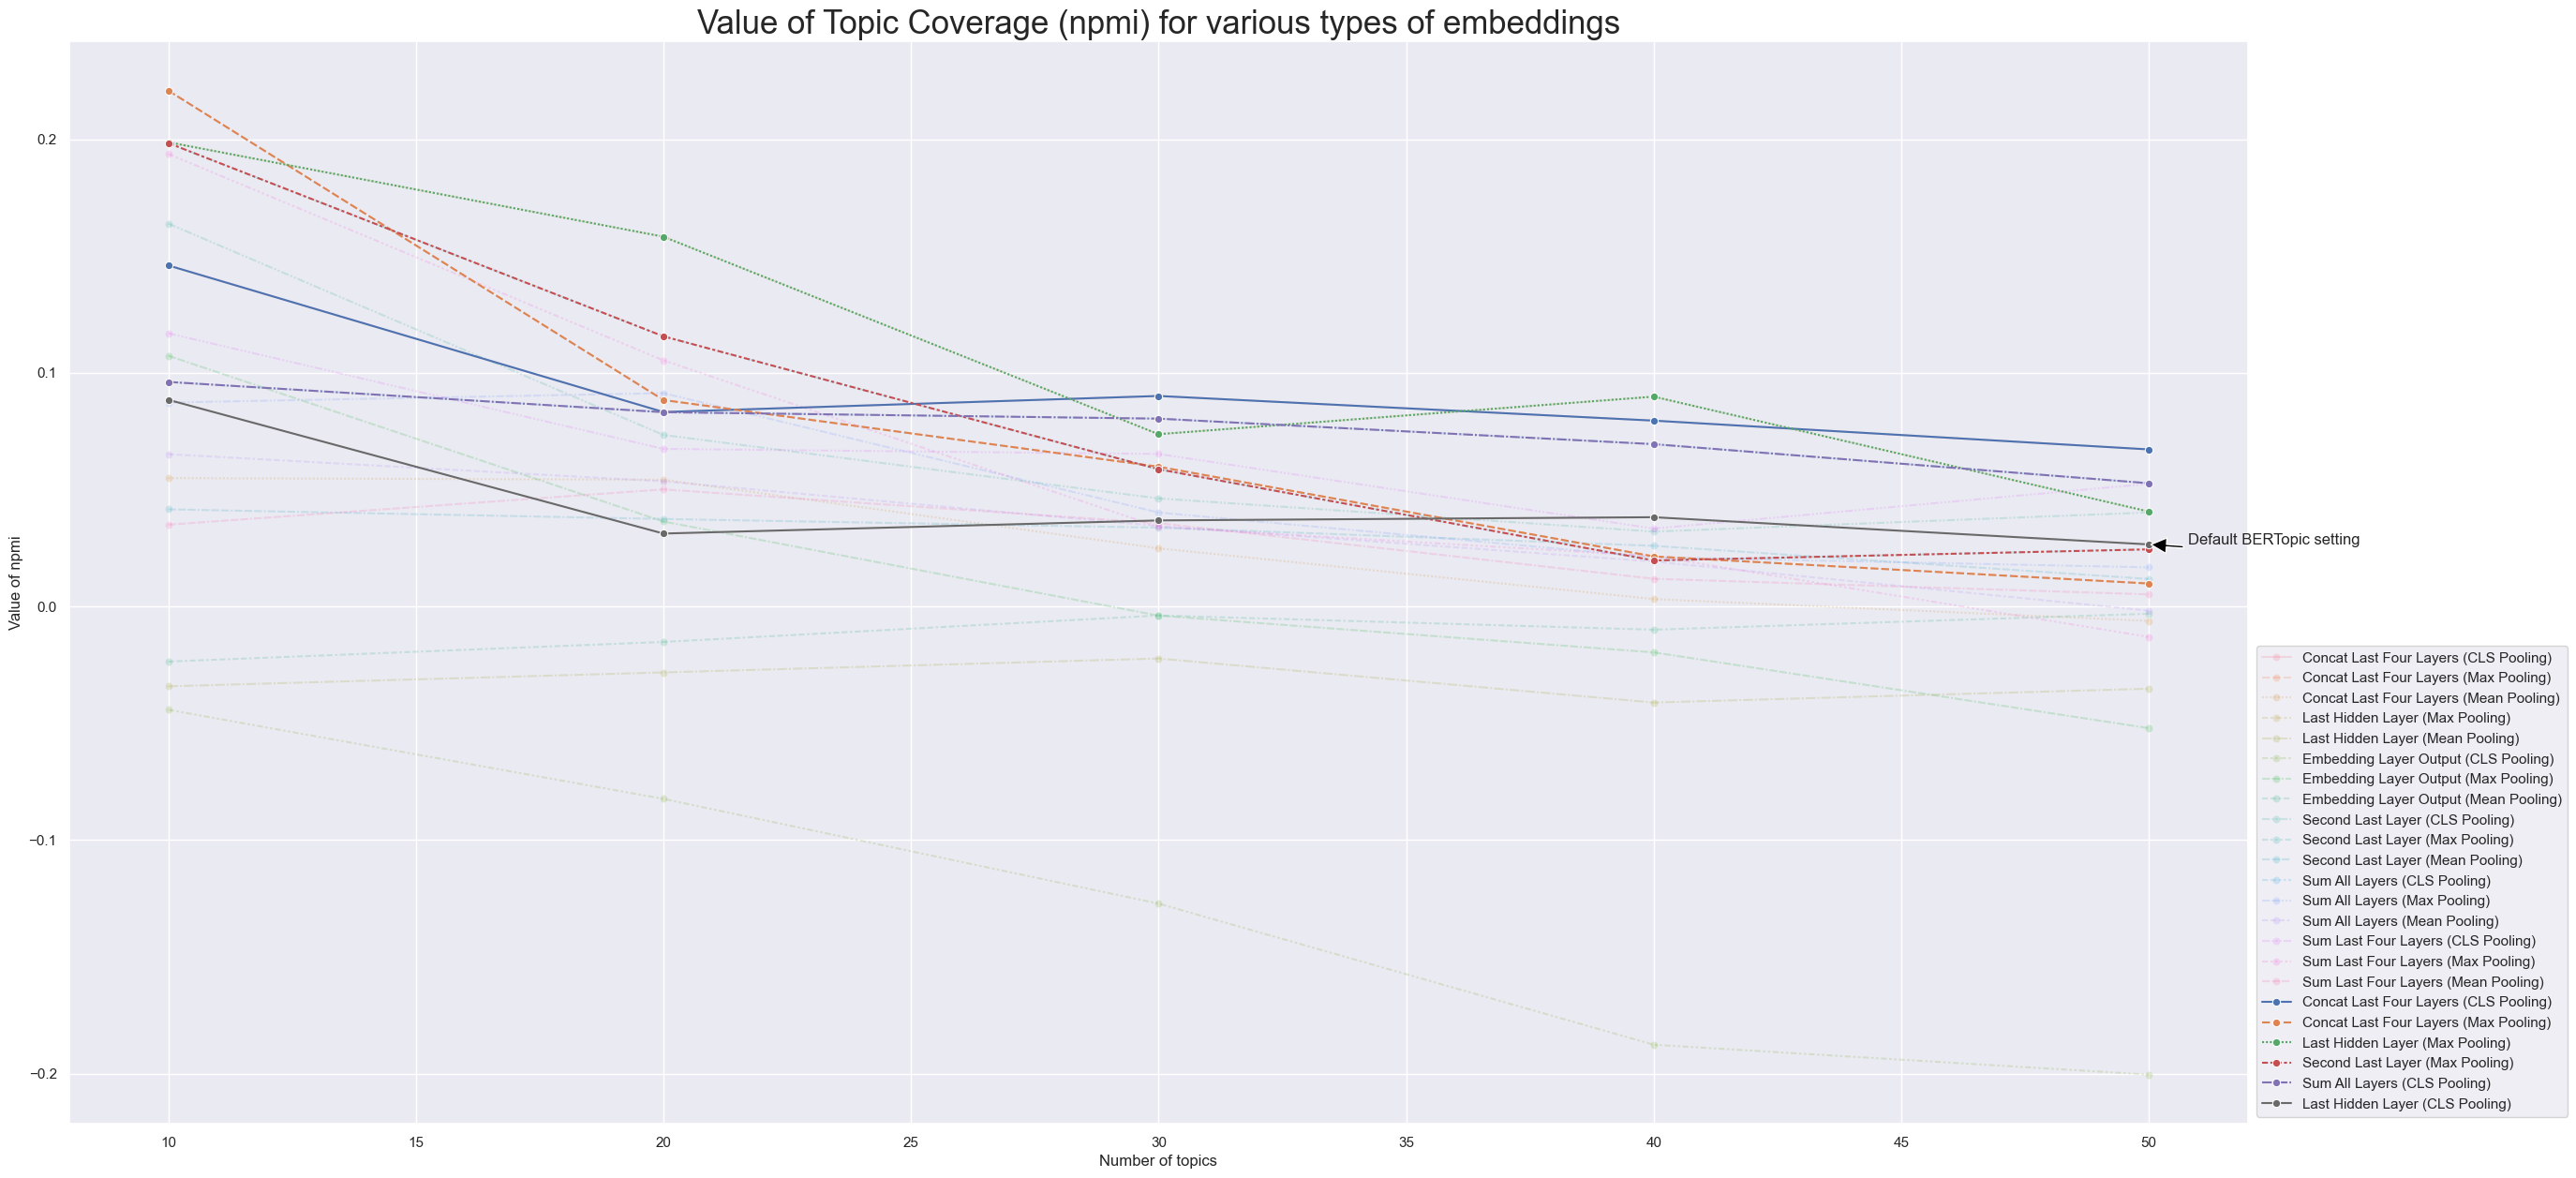

In [300]:
default_setting = results_grouped[
    results_grouped["embedding_retrieval_type"] == "Last Hidden Layer (CLS Pooling)"
]

results_grouped = results_grouped[
    results_grouped["embedding_retrieval_type"] != "Last Hidden Layer (CLS Pooling)"
]

fig, ax = plt.subplots()
sns.lineplot(
    data=results_grouped,
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=0.2,
    marker="o",
    ax=ax,
)
sns.lineplot(
    data=results_grouped[results_grouped["embedding_retrieval_type"].isin(top_categories_npmi)],
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=1,
    marker="o",
    ax=ax,
)

sns.lineplot(
    data=default_setting,
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    color="dimgrey",
    alpha=1,
    marker="o",
    ax=ax,
)
plt.xlabel("Number of topics")
plt.ylabel("Value of npmi")
plt.title("Value of Topic Coverage (npmi) for various types of embeddings", size=25)

line = ax.lines[-2]
x_data = line.get_xdata()
y_data = line.get_ydata()
x_to_annotate = x_data[-1]
y_to_annotate = y_data[-1]

ax.annotate(
    "Default BERTopic setting",
    xy=(x_to_annotate, y_to_annotate),
    xytext=(x_to_annotate + 0.8, y_to_annotate),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
)

ax.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
plt.show()

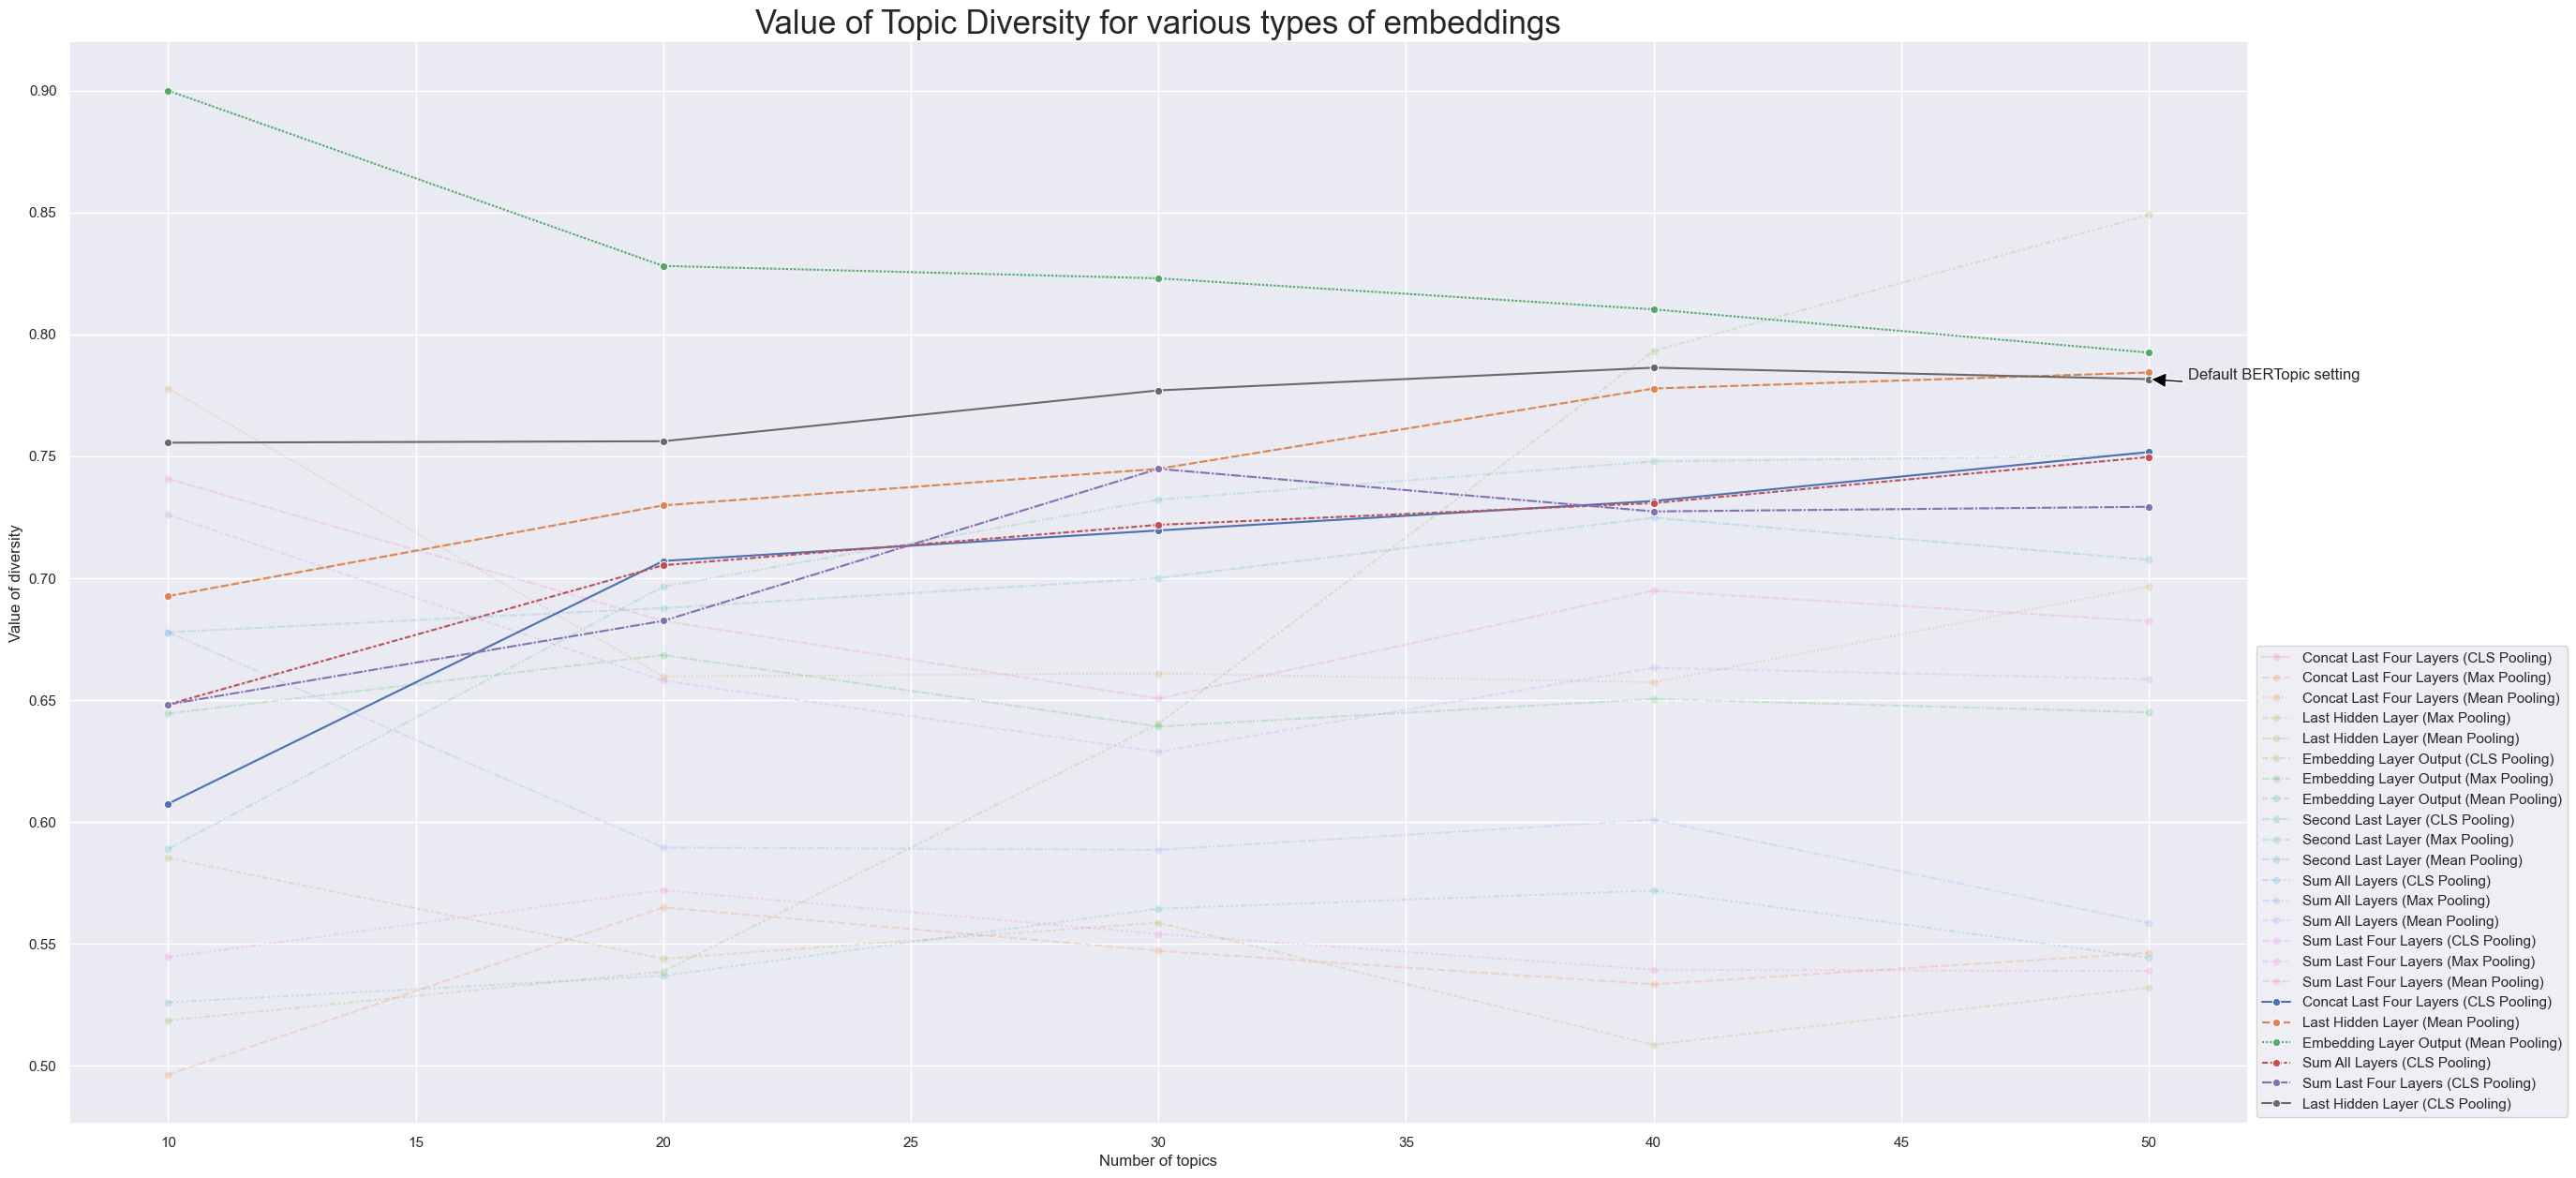

In [301]:
fig, ax = plt.subplots()
sns.lineplot(
    data=results_grouped,
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=0.2,
    marker="o",
    ax=ax,
)
sns.lineplot(
    data=results_grouped[results_grouped["embedding_retrieval_type"].isin(top_categories_diversity)],
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=1,
    marker="o",
    ax=ax,
)

sns.lineplot(
    data=default_setting,
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    color="dimgrey",
    alpha=1,
    marker="o",
    ax=ax,
)
plt.xlabel("Number of topics")
plt.ylabel("Value of diversity")
plt.title("Value of Topic Diversity for various types of embeddings", size=25)

line = ax.lines[-2]
x_data = line.get_xdata()
y_data = line.get_ydata()
x_to_annotate = x_data[-1]
y_to_annotate = y_data[-1]

ax.annotate(
    "Default BERTopic setting",
    xy=(x_to_annotate, y_to_annotate),
    xytext=(x_to_annotate + 0.8, y_to_annotate),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
)

ax.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
plt.show()